In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import random

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import *
from utils import *
#get_device, get_noise, init_weights, plot_tensor_images, plot_losses, Positive, RevKlActivation
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter

In [3]:
# create dataloader
batch_size = 128
device = get_device()

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

Time is 0.020090579986572266 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


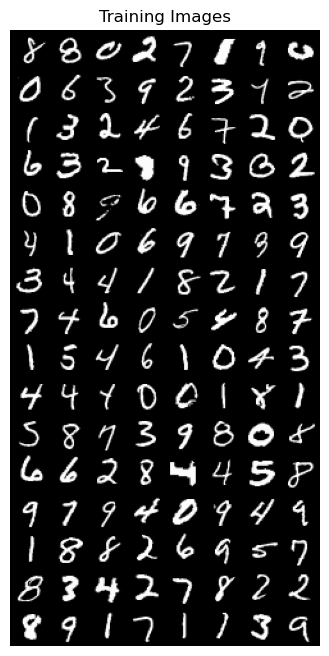

In [4]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [6]:
latent_dim = 100
latent_dim_bhs = 28*28
batch_size_bhs = 128
test_noise = get_noise(25, latent_dim, device)
test_noise_bhs = get_noise(25, latent_dim_bhs, device)

## First I train a Wasserstein GAN

In [10]:
training_params = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=1,
                                 num_dis_updates=5,
                                 num_gen_updates=1,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [11]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist(28*28).apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [13]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 29.663182	Loss_C : -2.723703	Loss_G : -8.112035		
Total_Time : 29.666198
Loss_C : -2.723703
Loss_G : -8.112035
Loss_C_Mean : -2.673036
Loss_G_Mean : -6.605020

----------------------------------------------



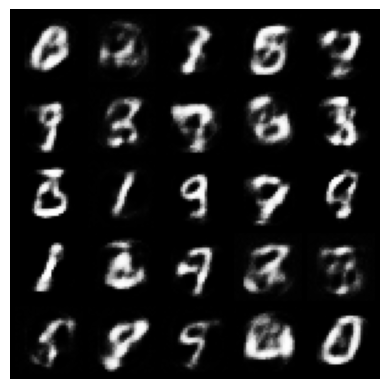

In [14]:
# show generated images
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=25)

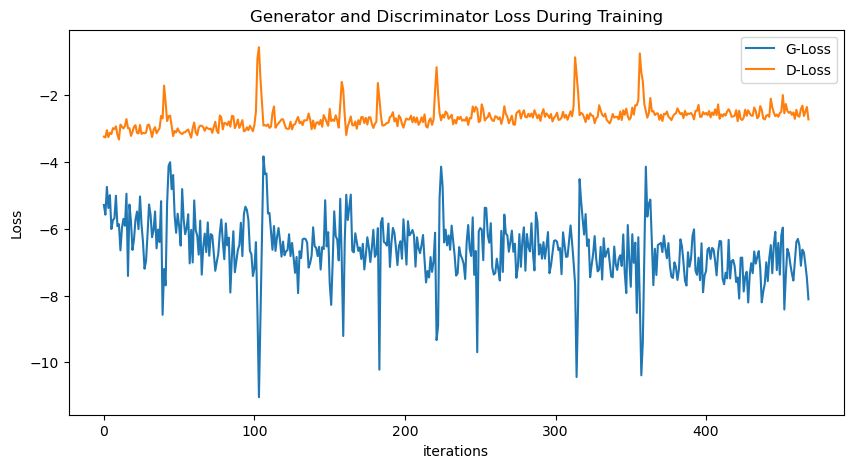

In [15]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

## BHS Gan
$f^*(x) = 2(-1+\sqrt{1+x})\exp(\sqrt{1+x})$

In [19]:
torch.manual_seed(1)
random.seed(1)

training_params_bhs = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_bhs = GeneratorBhsMnist(latent_dim_bhs)
discriminator_bhs = DiscriminatorBhsMnist(Positive, 28*28)
trainer_bhs = Trainer(training_params_bhs, generator_bhs, discriminator_bhs, device=device)

In [20]:
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 26.816511	Loss_C : 0.016312	Loss_G : -0.056185		
Total_Time : 26.819504
Loss_C : 0.016312
Loss_G : -0.056185
Loss_C_Mean : 0.028211
Loss_G_Mean : -0.188833

----------------------------------------------



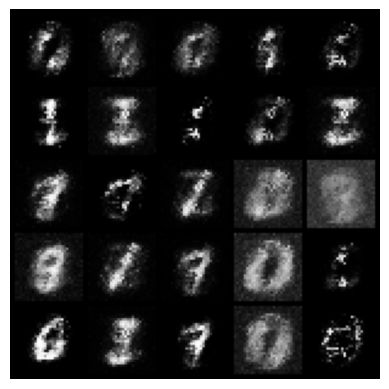

In [21]:
# show generated images
generated_images_bhs = trained_bhsgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_bhs, num_images=25)

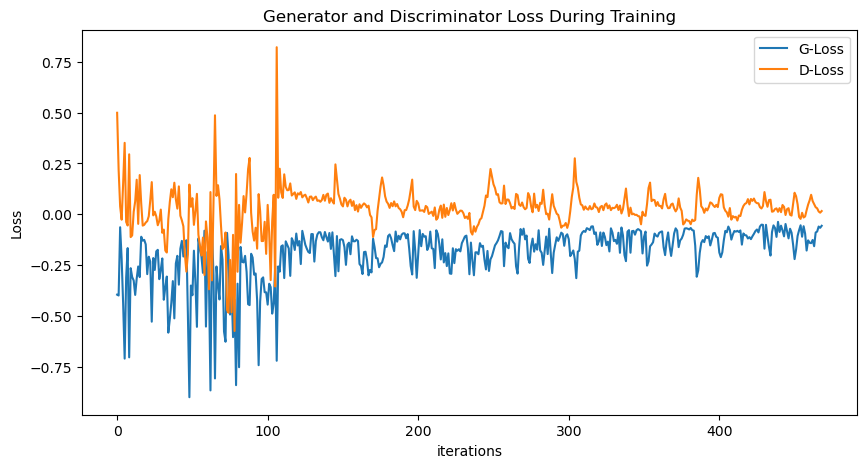

In [22]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## KL GAN
$f^*(x) = \exp(x-1)$


In [24]:
torch.manual_seed(1)
random.seed(1)

training_params_KL = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_KL = GeneratorBhsMnist(latent_dim_bhs)
discriminator_KL = DiscriminatorBhsMnist(nn.Identity, 28*28)
trainer_kl = Trainer(training_params_KL, generator_KL, discriminator_KL, device=device)

In [25]:
trained_klgan = trainer_kl.train_gan(dataloader, get_dis_loss_kl, get_gen_loss_kl, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 26.164689	Loss_C : -0.828055	Loss_G : -0.766253	
Total_Time : 26.164689
Loss_C : -0.828055
Loss_G : -0.766253
Loss_C_Mean : -0.459519
Loss_G_Mean : -0.733995

----------------------------------------------



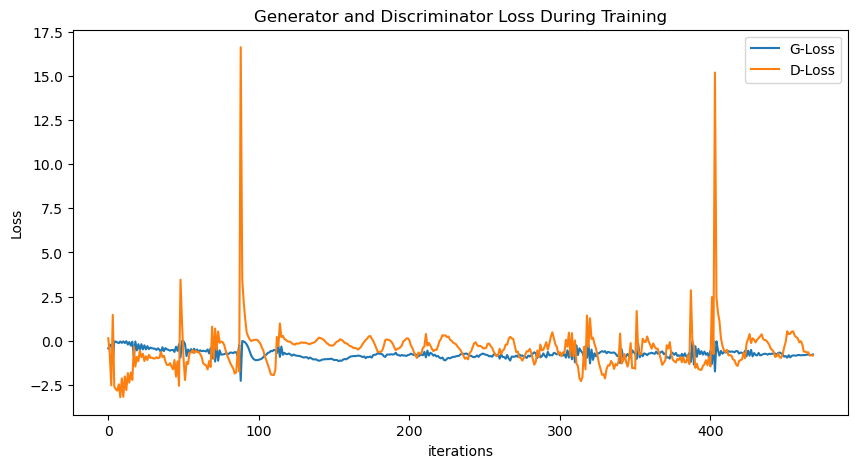

In [26]:
plot_losses(trained_klgan.generator_losses, trained_klgan.discriminator_losses)

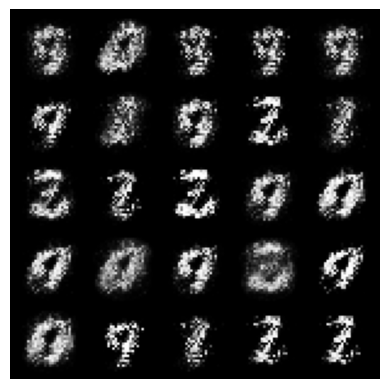

In [27]:
generated_images_kl = trained_klgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_kl, num_images=25)

## Rev KL GAN
$f^*(x) = -1 - \log(x)$


In [28]:
torch.manual_seed(2)
random.seed(2)

training_params_RKL = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=4, num_gen_updates=3,
                                    beta_1=0.5, batch_size=batch_size_bhs)
generator_RKL = GeneratorBhsMnist(latent_dim_bhs)
discriminator_RKL = DiscriminatorBhsMnist(RevKlActivation, 28 * 28)
trainer_rkl = Trainer(training_params_RKL, generator_RKL, discriminator_RKL, device=device)


In [29]:
trained_rklgan = trainer_rkl.train_gan(dataloader, get_dis_loss_rkl, get_gen_loss_rkl, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 27.542605	Loss_C : 0.349693	Loss_G : -0.320172	
Total_Time : 27.542605
Loss_C : 0.349693
Loss_G : -0.320172
Loss_C_Mean : 0.362610
Loss_G_Mean : -0.340522

----------------------------------------------



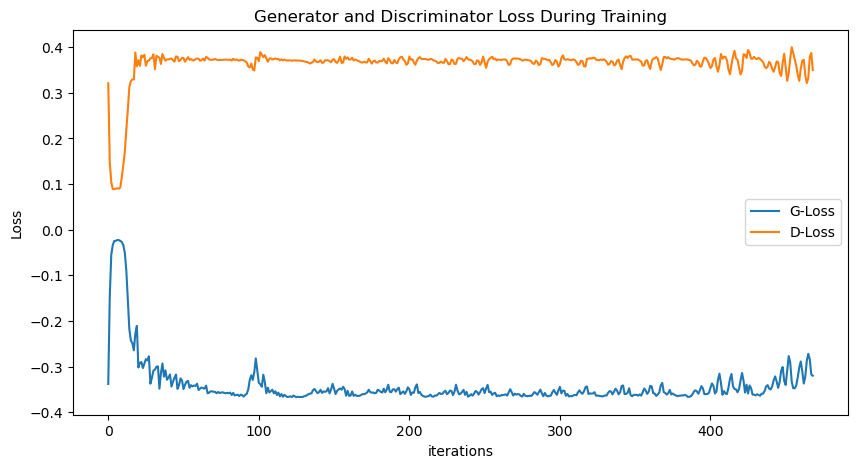

In [30]:
plot_losses(trained_rklgan.generator_losses, trained_rklgan.discriminator_losses)

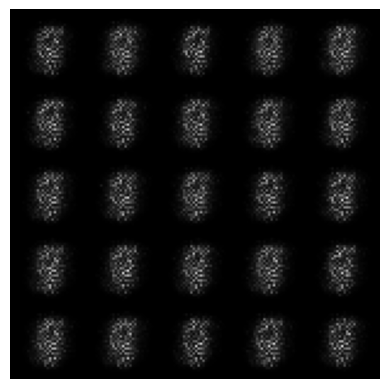

In [31]:
generated_images_rkl = trained_rklgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_rkl, num_images=25)

## Pearson GAN
$f^*(x) = \frac{1}{4} x^2 + x$

In [32]:
torch.manual_seed(2)
random.seed(2)

training_params_pgan = TrainingParams(lr_dis=0.0002, lr_gen=0.001, num_epochs=1, num_dis_updates=5, num_gen_updates=1,
                                     beta_1=0.5, batch_size=batch_size_bhs)
generator_pgan = GeneratorBhsMnist(latent_dim_bhs)
discriminator_pgan = DiscriminatorBhsMnist(nn.Identity,28 * 28)
trainer_kl = Trainer(training_params_pgan, generator_pgan, discriminator_pgan, device=device)


In [33]:
trained_pgan = trainer_kl.train_gan(dataloader, get_dis_loss_p, get_gen_loss_p, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 16.818188	Loss_C : -3.344929	Loss_G : -0.000010		
Total_Time : 16.821989
Loss_C : -3.344929
Loss_G : -0.000010
Loss_C_Mean : -1.346084
Loss_G_Mean : nan

----------------------------------------------



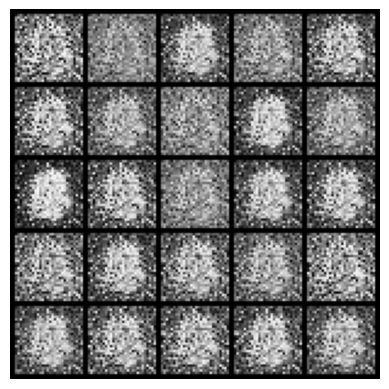

In [34]:
generated_images_pgan = trained_pgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_pgan, num_images=25)


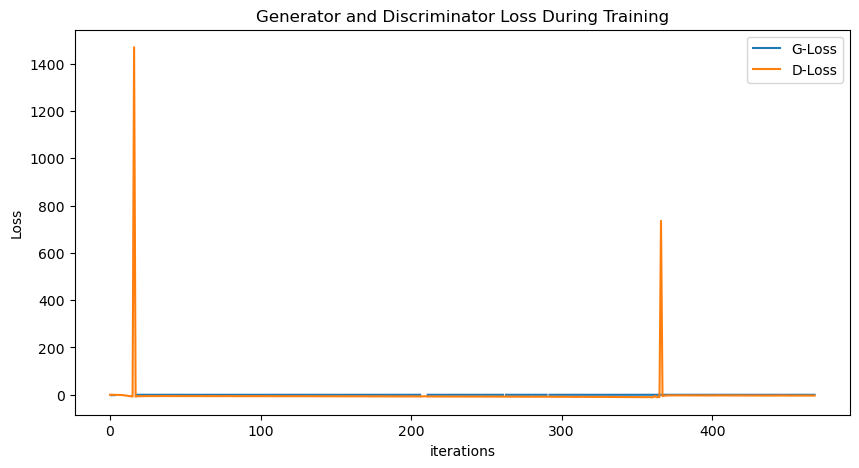

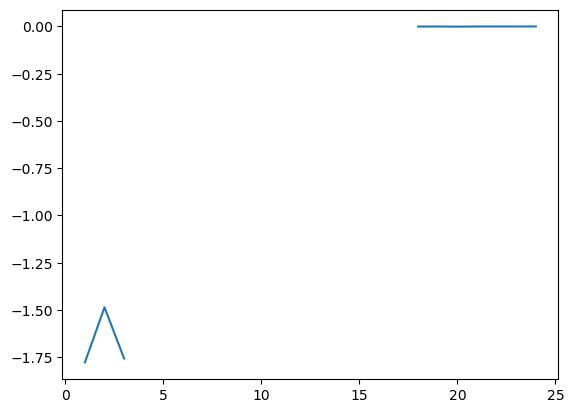

In [35]:
plot_losses(trained_pgan.generator_losses, trained_pgan.discriminator_losses)
plt.plot(trained_pgan.generator_losses[0:25])

## GAN GAN
$f^*(x) = -\log(1-\exp(x))$

In [36]:
torch.manual_seed(2)
random.seed(2)

training_params_GAN = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=4, num_gen_updates=3,
                                    beta_1=0.5, batch_size=batch_size_bhs)
generator_GAN = GeneratorBhsMnist(latent_dim_bhs)
discriminator_GAN = DiscriminatorBhsMnist(RevKlActivation, 28 * 28)
trainer_gan = Trainer(training_params_GAN, generator_GAN, discriminator_GAN, device=device)

In [37]:
trained_gan = trainer_gan.train_gan(dataloader, get_dis_loss_gan, get_gen_loss_gan, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 30.155134	Loss_C : 0.014076	Loss_G : -0.045742	
Total_Time : 30.155134
Loss_C : 0.014076
Loss_G : -0.045742
Loss_C_Mean : 0.030846
Loss_G_Mean : -0.074085

----------------------------------------------



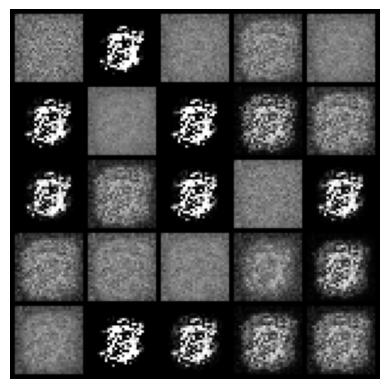

In [38]:
generated_images_gan = trained_gan.generator(test_noise_bhs)
plot_tensor_images(generated_images_gan, num_images=25)

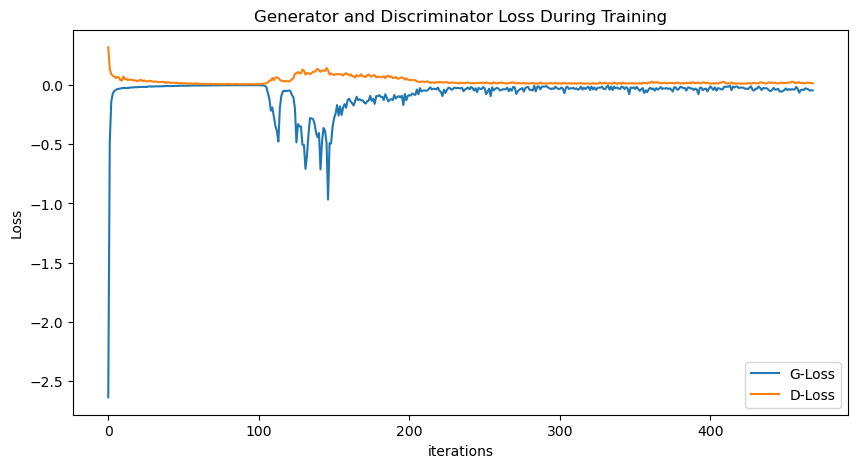

In [39]:
plot_losses(trained_gan.generator_losses, trained_gan.discriminator_losses)


## IPM BHS GAN

In [40]:
training_params_ipm = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=5, num_gen_updates=1, beta_1=0.5, batch_size=batch_size)
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist(28*28).apply(init_weights)
trainer_ipm = Trainer(training_params_ipm, generator_ipm, discriminator_ipm, device=device)

In [41]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 24.486318	Loss_C : 15.665789	Loss_G : -360.976562			
Total_Time : 24.487316
Loss_C : 15.665789
Loss_G : -360.976562
Loss_C_Mean : -109.922231
Loss_G_Mean : 1.689425

----------------------------------------------



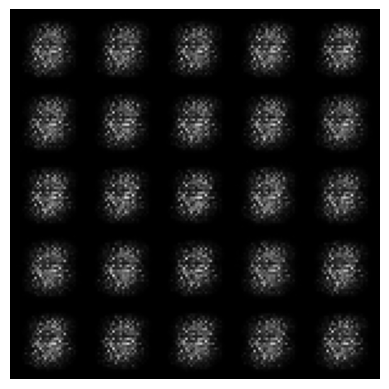

In [42]:
# show generated images
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=25)

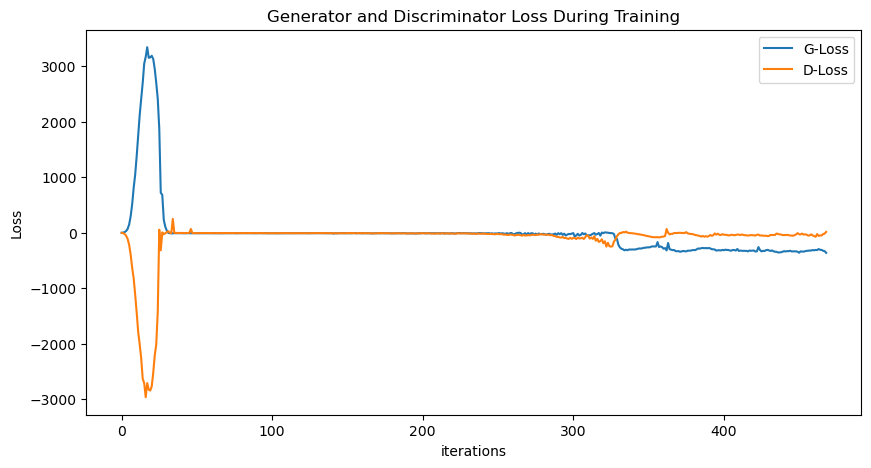

In [43]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)